In [1]:
import numpy as np
from sklearn.decomposition import PCA
import heapq
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
data = np.load('C:\\Users\\fateme\\Desktop\\SPR_HW4\\train-ubyte\\a.npy')
label = np.load('C:\\Users\\fateme\\Desktop\\SPR_HW4\\train-ubyte\\b.npy')

In [3]:
nsamples, nx, ny = data.shape
dt = data.reshape((nsamples,nx*ny))

In [4]:
dt.shape

(80000, 784)

In [5]:
label.shape

(80000,)

# PCA

In [6]:
def PCA(x):
    #compute mean
    mean = np.mean(x, axis= 0)
    mean_data = x - mean

    # Compute covariance matrix
    cov = np.cov(mean_data.T)
    cov = np.round(cov, 2)
    
    # Perform eigen decomposition of covariance matrix
    eig_val, eig_vec = np.linalg.eig(cov)
    
    # Sort eigen values and corresponding eigen vectors in descending order
    indices = np.arange(0,len(eig_val), 1)
    indices = ([x for _,x in sorted(zip(eig_val, indices))])[::-1]
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:,indices]
    max_eig = eig_val[0:20]
    print("top 20 of Sorted Eigen values ", max_eig, "\n")
    
    # Get explained variance
    sum_eig_val = np.sum(eig_val)
    explained_variance = eig_val/ sum_eig_val
    cumulative_variance = np.cumsum(explained_variance)
    
    # Take transpose of eigen vectors with data
    pca_data = np.dot(mean_data, eig_vec)
    return pca_data,eig_val

In [7]:
pca_data,eig_value = PCA(dt)

top 20 of Sorted Eigen values  [284765.00077037 276909.80324943 159995.1528915  135060.21091957
 105714.10748809 101280.08805835  87571.24118236  80833.85961203
  72591.14578202  64722.4816955   58352.21724876  55682.61059702
  53992.2666051   51298.59036831  46820.62174801  46547.7500008
  45423.80578955  43774.08701081  42466.96332802  41816.50578826] 



In [8]:
res = pd.DataFrame(pca_data).iloc[:,[0,1,2]]
res

,0,1,2
0,777.369437,-657.780264,-86.055767
1,-905.040011,-829.132990,250.092487
2,-229.551080,-279.851590,-328.107877
3,-13.186424,-608.739511,-673.159384
4,591.372207,-543.083232,152.556926
...,...,...,...
79995,535.685062,-238.064248,-379.426021
79996,-117.330591,433.831772,14.341144
79997,-414.526747,728.009121,-70.851290
79998,-312.457935,657.495104,-248.786035


In [9]:
first = np.array(res.iloc[:,0])
second = np.array(res.iloc[:,1])
third = np.array(res.iloc[:,2])

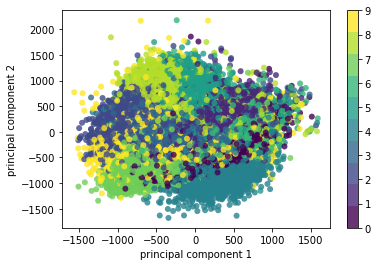

In [10]:
x1, x2 = first, second
y = label
plt.scatter(x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 10))

plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.colorbar()
plt.show()

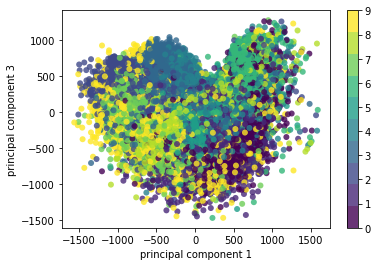

In [11]:
x1, x2 = first, third
y = label
plt.scatter(x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 10))

plt.xlabel("principal component 1")
plt.ylabel("principal component 3")
plt.colorbar()
plt.show()

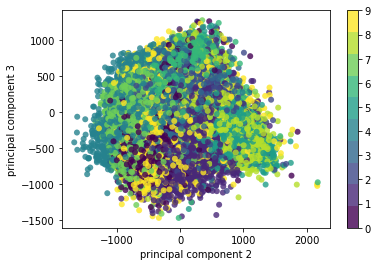

In [12]:
x1, x2 = second , third
y = label
plt.scatter(x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 10))

plt.xlabel("principal component 2")
plt.ylabel("principal component 3")
plt.colorbar()
plt.show()

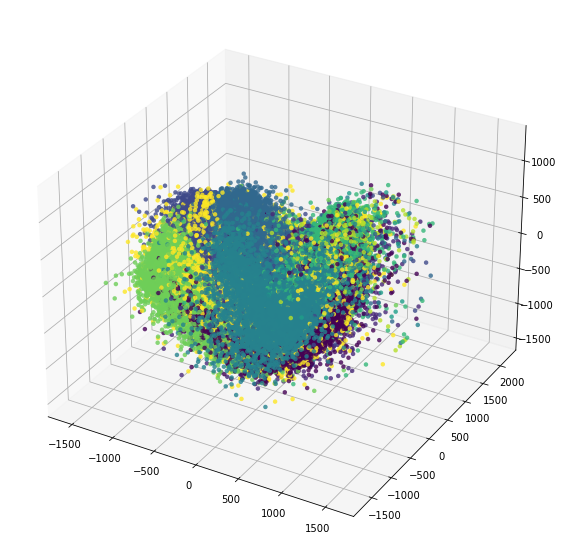

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
zline = third
xline = first
yline = second
b = ax.scatter3D(first,second,third, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 10))

# LDA

Shape of X: (80000, 784)
Shape of transformed X: (80000, 2)


C:\Users\fateme\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


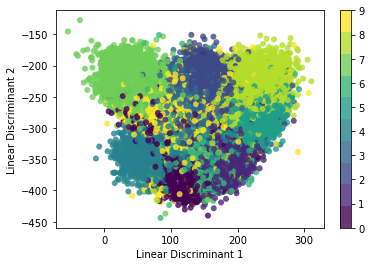

In [15]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # (4, n_c) * (n_c, 4) = (4,4) -> transpose
            SW += (X_c - mean_c).T.dot((X_c - mean_c))

            # (4, 1) * (1, 4) = (4,4) -> reshape
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.pinv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)


# Testing
if __name__ == "__main__":
    # Imports
    import matplotlib.pyplot as plt
    from sklearn import datasets

#     data = datasets.load_iris()
    X, y = dt,label

    # Project the data onto the 2 primary linear discriminants
    lda = LDA(2)
    lda.fit(X, y)
    X_projected = lda.transform(X)

    print("Shape of X:", X.shape)
    print("Shape of transformed X:", X_projected.shape)

    x1, x2 = X_projected[:, 0], X_projected[:, 1]

    plt.scatter(
        x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 10)
    )

    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.colorbar()
    plt.show()

# k-Means
##### Select random initial centroids and set K = 3, 7, 10.

In [16]:
fs = pd.DataFrame(pca_data).iloc[:,[0,1]]
X_train, X_test, y_train, y_test = train_test_split(fs, label, test_size=0.8 , random_state=10)

In [19]:
C = KMeans(n_clusters = 3).fit(X_train)
pred = C.predict(X_test)
accuracy_score(y_test,pred)

0.123796875

In [20]:
C = KMeans(n_clusters = 7).fit(X_train)
pred = C.predict(X_test)
accuracy_score(y_test,pred)

0.10353125

In [21]:
C = KMeans(n_clusters = 10).fit(X_train)
pred = C.predict(X_test)
accuracy_score(y_test,pred)

0.05665625

### K = 3, initial centroids are the mean of samples of classes {1,3,5,7}, {2,4}, and {6,8,9,10}

In [17]:
df = pd.DataFrame(fs)
df[2] = label
np.unique(label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [23]:
one = df.loc[df[2] == 0].iloc[:,[0,1]].mean()
three = df.loc[df[2] == 2].iloc[:,[0,1]].mean()
five = df.loc[df[2] == 4].iloc[:,[0,1]].mean()
seven = df.loc[df[2] == 6].iloc[:,[0,1]].mean()
a =( one+three+five+seven)/4
a

0    222.357353
1   -219.280847
dtype: float64

In [24]:
two = df.loc[df[2] == 1].iloc[:,[0,1]].mean()
four = df.loc[df[2] == 3].iloc[:,[0,1]].mean()
b = (two + four)/2
b

0      8.033282
1    183.412071
dtype: float64

In [25]:
six = df.loc[df[2] == 5].iloc[:,[0,1]].mean()
eight = df.loc[df[2] == 7].iloc[:,[0,1]].mean()
nine = df.loc[df[2] == 8].iloc[:,[0,1]].mean()
ten = df.loc[df[2] == 9].iloc[:,[0,1]].mean()
c = (six + eight + nine + ten)/4
c

0   -227.562657
1    127.973875
dtype: float64

In [27]:
fs = pd.DataFrame(pca_data).iloc[:,[0,1]]
X_train, X_test, y_train, y_test = train_test_split(fs, label, test_size=0.8 , random_state=10)
z = [a,b,c]
z = np.array(z)

In [28]:
C = KMeans(n_clusters=3,init=z).fit(X_train)
pred = C.predict(X_test)
accuracy_score(y_test,pred)

C:\Users\fateme\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


0.1808125

### K = 7, initial centroids are the mean of samples of classes {1,2,5}, {3}, {4}, {6}, {7}, {9} and {8,10}

In [29]:
one = df.loc[df[2] == 0].iloc[:,[0,1]].mean()
two = df.loc[df[2] == 1].iloc[:,[0,1]].mean()
five = df.loc[df[2] == 4].iloc[:,[0,1]].mean()
a = (one + two + five)/3
a

0    371.351297
1   -199.074861
dtype: float64

In [30]:
three = df.loc[df[2] == 2]
b = three.iloc[:,[0,1]].mean()
b

0   -531.229266
1     32.387306
dtype: float64

In [31]:
four = df.loc[df[2] == 3]
c = four.iloc[:,[0,1]].mean()
c

0   -289.010039
1    104.799853
dtype: float64

In [32]:
six = df.loc[df[2] == 5]
d = six.iloc[:,[0,1]].mean()
d

0     30.159174
1    722.833920
dtype: float64

In [33]:
seven = df.loc[df[2] == 6]
e = seven.iloc[:,[0,1]].mean()
e

0    611.681390
1    -50.261822
dtype: float64

In [34]:
nine = df.loc[df[2] == 8]
f = nine.iloc[:,[0,1]].mean()
f

0    -95.495455
1    594.790191
dtype: float64

In [35]:
eight = df.loc[df[2] == 7].iloc[:,[0,1]].mean()
ten = df.loc[df[2] == 9].iloc[:,[0,1]].mean()
g = (eight + ten )/2
g

0   -422.457174
1   -402.864306
dtype: float64

In [36]:
res = [a,b,c,d,e,f,g]
res = np.array(res)

In [37]:
C = KMeans(n_clusters=7,init=res).fit(X_train)
pred = C.predict(X_test)
accuracy_score(y_test,pred)

C:\Users\fateme\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


0.158640625

### K = 10, initial centroids are the mean of sample of each of the 10 classes separately.

In [18]:
one = df.loc[df[2] == 0]
a = one.iloc[:,[0,1]].mean()
a

0    456.559061
1   -344.440304
dtype: float64

In [19]:
two = df.loc[df[2] == 1]
b = two.iloc[:,[0,1]].mean()
b

0    305.076603
1    262.024289
dtype: float64

In [20]:
three = df.loc[df[2] == 2]
c = three.iloc[:,[0,1]].mean()
c

0   -531.229266
1     32.387306
dtype: float64

In [21]:
four = df.loc[df[2] == 3]
d = four.iloc[:,[0,1]].mean()
d

0   -289.010039
1    104.799853
dtype: float64

In [22]:
five = df.loc[df[2] == 4]
e = five.iloc[:,[0,1]].mean()
e

0    352.418226
1   -514.808567
dtype: float64

In [23]:
six = df.loc[df[2] == 5]
f = six.iloc[:,[0,1]].mean()
f

0     30.159174
1    722.833920
dtype: float64

In [24]:
seven = df.loc[df[2] == 6]
g = seven.iloc[:,[0,1]].mean()
g

0    611.681390
1    -50.261822
dtype: float64

In [25]:
eight = df.loc[df[2] == 7]
h = eight.iloc[:,[0,1]].mean()
h

0   -583.403920
1   -597.132969
dtype: float64

In [26]:
nine = df.loc[df[2] == 8]
i = nine.iloc[:,[0,1]].mean()
i

0    -95.495455
1    594.790191
dtype: float64

In [27]:
ten = df.loc[df[2] == 9]
j = ten.iloc[:,[0,1]].mean()
j

0   -261.510427
1   -208.595644
dtype: float64

In [28]:
result = [a,b,c,d,e,f,g,h,i,j]
result = np.array(result)

In [29]:
C = KMeans(n_clusters=10,init=result).fit(X_train)
pred = C.predict(X_test)
accuracy_score(y_test,pred)

C:\Users\fateme\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


0.45646875

when we change the initial center to mean of each class the accuracy improve but it's still under 0.5

### part e

In [32]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca_dt = pca.fit(dt)

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))

Number of components explaining 95% variance: 270


In [33]:
ipca = IncrementalPCA(n_components=k)
image_recon = ipca.inverse_transform(ipca.fit_transform(dt[1:]))

In [34]:
new = image_recon.reshape(79999,28,28)

In [35]:
new.shape

(79999, 28, 28)

 ### 3 random samples : 

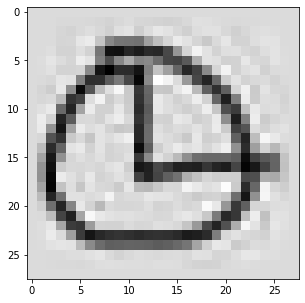

In [36]:
plt.figure(figsize=[200,5])
plt.imshow(new[1],cmap = plt.cm.gray)

(79999, 28, 28)

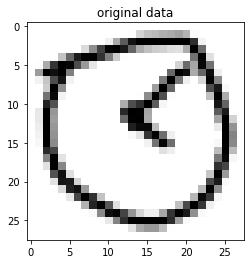

In [38]:
plt.imshow(data[1],'gray')
plt.title('original data')
data[1:].shape

Text(0.5, 1.0, 'original data')

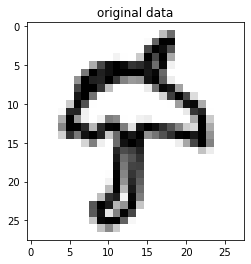

In [24]:
plt.imshow(data[50101],'gray')
plt.title('original data')

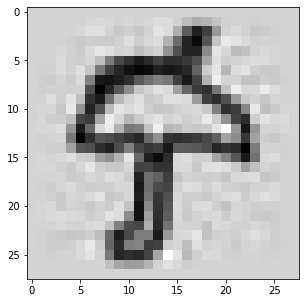

In [26]:
plt.figure(figsize=[20,5])
plt.imshow(new[50100],'gray')

Text(0.5, 1.0, 'original data')

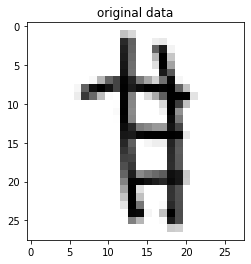

In [19]:
plt.imshow(data[70009],'gray')
plt.title('original data')

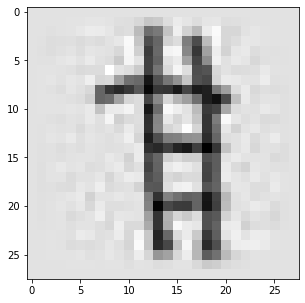

In [27]:
plt.figure(figsize=[200,5])
plt.imshow(new[70008],'gray')

### part f
Use K-Means to divide data into 10 clusters. Set the required parameters appropriately. Display 10 samples of each cluster randomly (100 in total) and comment on the results.

In [42]:
finall_result = pd.DataFrame(pca_data)
finall_result[785] = label
np.unique(label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
finall_result.shape

(80000, 785)

In [60]:
one = finall_result.loc[finall_result[785] == 0]
a = one.mean()
a

0      456.559061
1     -344.440304
2     -243.355831
3      128.755395
4       21.976512
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      0.000000
Length: 785, dtype: float64

In [61]:
two = finall_result.loc[finall_result[785] == 1]
b = two.mean()
b

0      305.076603
1      262.024289
2     -230.528675
3      230.492419
4       21.414044
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      1.000000
Length: 785, dtype: float64

In [62]:
three = finall_result.loc[finall_result[785] == 2]
c = three.mean()
c

0     -531.229266
1       32.387306
2      165.211363
3       70.646595
4      297.697568
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      2.000000
Length: 785, dtype: float64

In [63]:
four = finall_result.loc[finall_result[785] == 3]
d = four.mean()
d

0     -289.010039
1      104.799853
2      239.271288
3      -70.374422
4     -522.963903
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      3.000000
Length: 785, dtype: float64

In [64]:
five = finall_result.loc[finall_result[785] == 4]
e = five.mean()
e

0      352.418226
1     -514.808567
2       63.035788
3       42.607902
4     -142.164657
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      4.000000
Length: 785, dtype: float64

In [65]:
six = finall_result.loc[finall_result[785] == 5]
f = six.mean()
f

0       30.159174
1      722.833920
2     -188.201087
3     -231.384694
4      -13.599971
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      5.000000
Length: 785, dtype: float64

In [66]:
seven = finall_result.loc[finall_result[785] == 6]
g = seven.mean()
g

0      611.681390
1      -50.261822
2      445.416064
3      -90.694279
4      190.430440
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      6.000000
Length: 785, dtype: float64

In [67]:
eight = finall_result.loc[finall_result[785] == 7]
h = eight.mean()
h

0     -583.403920
1     -597.132969
2      -71.217700
3     -183.414505
4        9.283871
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      7.000000
Length: 785, dtype: float64

In [68]:
nine = finall_result.loc[finall_result[785] == 8]
i = nine.mean()
i

0      -95.495455
1      594.790191
2      -53.386972
3     -149.146706
4      168.269399
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      8.000000
Length: 785, dtype: float64

In [69]:
ten = finall_result.loc[finall_result[785] == 9]
j = ten.mean()
j

0     -261.510427
1     -208.595644
2     -124.459565
3      250.953647
4      -35.398173
          ...    
780      0.000000
781      0.000000
782      0.000000
783      0.000000
785      9.000000
Length: 785, dtype: float64

In [70]:
result = [a,b,c,d,e,f,g,h,i,j]
result = np.array(result)

In [71]:
C = KMeans(n_clusters=10,init=result).fit(finall_result)
pred = C.predict(finall_result)
accuracy_score(label,pred)

C:\Users\fateme\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


0.5756125